<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/magda/Github/deepul')
print(sys.path)

['/home/magda/Github/deepul/homeworks/hw1', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul']


In [4]:
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


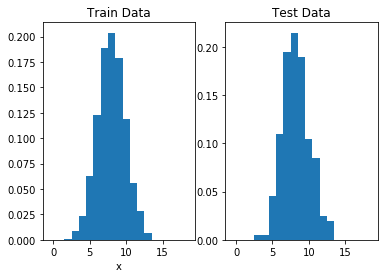

Dataset 2


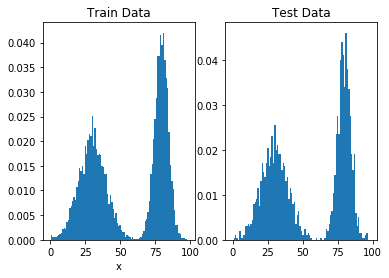

In [5]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

**sigmoid**

$$\sigma(x) = \frac{1}{1+e^{-x}} = \frac{e^x}{e^x + 1}$$
$$1 - \sigma(x) = \sigma(-x)$$
$$\sigma'(x) = \sigma(x) (1 - \sigma(x))$$

$$p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$$

$$\log p_\theta(x) = \log \sum_{i=1}^4 \exp \big( \log \pi_i + \log [\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]\big)$$

$$p_\theta(0) = \sum_{i=1}^4 \pi_i[\sigma((0 + 0.5 - \mu_i)/s_i) - \sigma(-\infty)]
= \sum_{i=1}^4 \exp \big( \log \pi_i + \log [\sigma((0 + 0.5 - \mu_i)/s_i)] \big)$$

$$p_\theta(d-1) = \sum_{i=1}^4 \pi_i[\sigma(\infty) - \sigma((d - 1 - 0.5 - \mu_i)/s_i)] =
\sum_{i=1}^4 \exp \big( \log \pi_i + \log [1 - \sigma((d - 1 - 0.5 - \mu_i)/s_i)] \big) = $$ 
$$ = \sum_{i=1}^4 \exp \big( \log \pi_i + \log [\sigma(-(d - 1 - 0.5 - \mu_i)/s_i)] \big)
$$

In [44]:
from exp_utils import *

class LogisticMixture(nn.Module):
    def __init__(self, d, num_mix):
        super(LogisticMixture, self).__init__()
        self.d = d
        self.num_mix = num_mix
        self.weights = nn.Parameter(torch.randn(num_mix))
        self.mu = nn.Parameter(torch.arange(num_mix).float() / (num_mix - 1) * d)
        self.log_scale = nn.Parameter(torch.randn(num_mix))
        
    def get_log_pdf(self, x):
        x = x.view(-1, 1).float()
        means = self.mu.view(1, -1)
        scale = self.log_scale.exp().view(1, -1)
        x_plus = (x - means + 0.5)/scale
        x_minus = (x - means - 0.5)/scale
        cdf_plus = torch.sigmoid(x_plus)
        cdf_minus = torch.sigmoid(x_minus)
        # mid range rounding
        cdf_dif = cdf_plus - cdf_minus
        log_pdfs_mid = torch.clamp(cdf_dif, min=1e-20).log()
        # edge values 0, d-1 rounding
        log_pdfs_zero = F.logsigmoid(x_plus)
        log_pdfs_d = F.logsigmoid(-x_minus)
        # choose correct rounding
        log_pdfs = torch.where(x==0, log_pdfs_zero,
                              torch.where(x==self.d-1, log_pdfs_d, log_pdfs_mid))
        # mixing pdfs
        log_pi = F.log_softmax(self.weights, 0)
        log_pdfs_weighted = log_pdfs + log_pi
        log_pdf = torch.logsumexp(log_pdfs_weighted, 1)
        return log_pdf
        
    def forward(self, x):
        return -self.get_log_pdf(x).mean()
    
    @property
    def probs(self):
        if next(self.parameters()).is_cuda:
            cats = torch.arange(self.d).float().cuda()
        else:
            cats = torch.arange(self.d).float()
        return self.get_log_pdf(cats).exp().detach()

In [49]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """

    """ YOUR CODE HERE """
    DEVICE = torch.device('cpu')
    train_loader, test_loader = get_loaders(train_data, test_data, bs=128)
    logmix = LogisticMixture(d, 4).to(DEVICE)
    adam_optim = torch.optim.Adam
    nll_train, nll_test = training(
        train_loader, test_loader,
        logmix, adam_optim, learn_rate=0.1, device=DEVICE)
    return nll_train, nll_test, logmix.probs.cpu().numpy()

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.0491


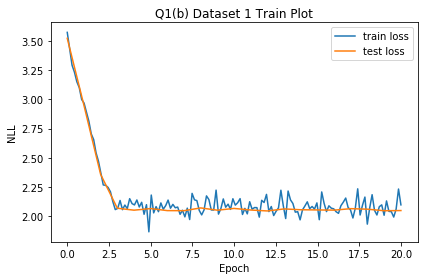

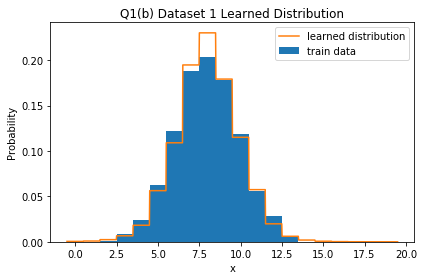

CPU times: user 2.47 s, sys: 0 ns, total: 2.47 s
Wall time: 553 ms


In [50]:
%time q1_save_results(1, 'b', q1_b)

Final Test Loss: 4.0405


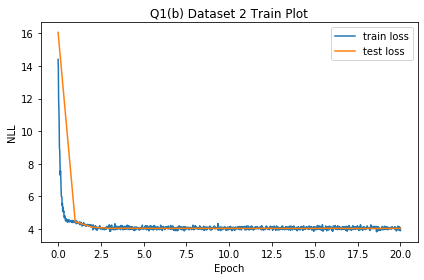

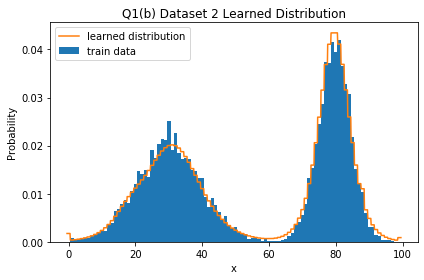

CPU times: user 10.7 s, sys: 158 ms, total: 10.9 s
Wall time: 2.08 s


In [51]:
%time q1_save_results(2, 'b', q1_b)